In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import sqlite3


# Les données clients

In [2]:
houses = pd.read_csv('house_dataset.csv')
houses.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
clients = pd.read_csv('clients.csv', index_col=0)
clients.head(3)

,id,first_name,last_name,phone,email
0,14,Jean-Michel,Dupont,456-456-112,Jean-Michel.Dupont@gmal.com
1,28,Jean-François,Grondin,456-456-123,Jean-François.Grondin@gmal.com
2,39,Amir,Cartoon,456-456-555,Amir.Cartoon@gmal.com


In [4]:
house_basic = pd.read_csv('house_basic.csv', index_col=0)
house_basic.head(3)

,Id,Neighborhood,BedroomAbvGr,GrLivArea,YearBuilt,SalePrice
0,1,CollgCr,3,1710,2003,208500
1,2,Veenker,3,1262,1976,181500
2,3,CollgCr,3,1786,2001,223500


In [5]:
agents = pd.read_csv('agents.csv', index_col=0)
agents.head(3)

,id,first_name,last_name,phone,email,date_embauche
0,0,Jean-Michel,Dupont,456-456-112,Jean-Michel.Dupont@gmal.com,19/10/2000
1,1,Nour,Halimi,456-456-111,Nour.Halimmi@gmal.com,19/05/2016


In [6]:
transactions = pd.read_csv('transactions.csv', index_col=0)
transactions.head()

,id,client_id,house_id,agent_id,date_transac
0,100,14,1433,0,08/02/2021
1,101,28,1450,0,22/09/2022
2,102,39,11,1,19/08/2020
3,103,46,12,1,06/12/2020
4,104,50,14,1,14/05/2021


# Création de votre base de données

In [7]:
conn = sqlite3.connect('database_jmi.sqlite')
c = conn.cursor()

In [8]:
conn = sqlite3.connect('database_jmi.sqlite')
#print(conn)
c = conn.cursor()

c.execute("""CREATE TABLE IF NOT EXISTS clients (   
	id INTEGER PRIMARY KEY,  
	first_name TEXT NOT NULL,
	last_name TEXT NOT NULL,
	email TEXT NOT NULL UNIQUE,
	phone TEXT NOT NULL UNIQUE
);""")
          
c.execute("""CREATE TABLE IF NOT EXISTS house_basic (
	Id INTEGER PRIMARY KEY,
	Neighborhood TEXT NOT NULL,
	BedroomAbvGr INTEGER NOT NULL,
	GrLivArea INTEGER NOT NULL,
	YearBuilt INTEGER NOT NULL,
	SalePrice INTEGER NOT NULL
);""")


c.execute("""CREATE TABLE IF NOT EXISTS agents (
	id INTEGER PRIMARY KEY,
	first_name TEXT NOT NULL,
	last_name TEXT NOT NULL,
	email TEXT NOT NULL UNIQUE,
	phone INTEGER NOT NULL UNIQUE,
    date_embauche DATE NOT NULL UNIQUE   
)""")

c.execute("""CREATE TABLE IF NOT EXISTS transactions (
	id INTEGER PRIMARY KEY,
	client_id INTEGER NOT NULL,
	house_id INTEGER NOT NULL,
	price INTEGER NOT NULL UNIQUE,
	date_transac DATE NOT NULL UNIQUE,
    agent_id INTEGER NOT NULL UNIQUE,
    CONSTRAINT fk_house
        FOREIGN KEY (Id)
        REFERENCES house_basic(Id)
    CONSTRAINT fk_clients
        FOREIGN KEY (id)
        REFERENCES clients(id)
    CONSTRAINT fk_agents
        FOREIGN KEY (id)
        REFERENCES agents(id)
)""")





clients.to_sql('clients', con=conn, if_exists='replace', index=False)
house_basic.to_sql('house_basic', con=conn, if_exists='replace', index=False)
agents.to_sql('agents', con=conn, if_exists='replace', index=False)
transactions.to_sql('transactions', con=conn, if_exists='replace', index=False)


c.execute("""
UPDATE transactions SET 
date_transac = substr(date_transac, 7, 4) || '-' || substr(date_transac, 4,2) || '-' || substr(date_transac, 1,2)
""")

conn.commit()


# Requête métiers

## KPI - meilleur agent

In [9]:
query = """ 
WITH temp AS
(SELECT id, last_name as name
FROM agents)
SELECT temp.id as agent_id, 
        name, 
        COUNT(SalePrice) AS nombres_ventes,
        AVG(SalePrice) AS ventes_moyennes, 
        SUM(SalePrice) AS ventes_totales,
        (SUM(SalePrice) * 100.0 )/SUM(SUM(SalePrice)) OVER () AS '% des ventes totales'
FROM transactions as t
LEFT JOIN temp ON temp.id = t.agent_id
LEFT JOIN house_basic as hb ON hb.id = t.house_id
GROUP BY temp.name
"""

df = pd.read_sql(query, conn)
df

,agent_id,name,nombres_ventes,ventes_moyennes,ventes_totales,% des ventes totales
0,0,Dupont,8,135437.500000,1083500,26.347786
1,1,Halimi,13,232984.615385,3028800,73.652214


### par agent avec temporalité

In [11]:
query = """ 

SELECT  last_name as name,
        strftime('%m-%Y',date_transac) AS month_year,
        SUM(SalePrice) AS ventes_totales
FROM transactions as t
LEFT JOIN agents ON agents.id = t.agent_id
LEFT JOIN house_basic as hb ON hb.id = t.house_id
GROUP BY name, month_year
ORDER BY name, date(date_transac)
"""

df_agent_time = pd.read_sql(query, conn)
df_agent_time

,name,month_year,ventes_totales
0,Dupont,10-2020,282000
1,Dupont,02-2021,64500
2,Dupont,06-2021,373000
3,Dupont,01-2022,272000
4,Dupont,09-2022,92000
5,Halimi,04-2020,639800
6,Halimi,08-2020,129500
7,Halimi,12-2020,345000
8,Halimi,05-2021,279500
9,Halimi,11-2021,361000


## KPI - catégories de ventes

### par quartier

#### toutes les ventes

In [13]:
query = """ 
SELECT  hb.Id, 
Neighborhood,
BedroomAbvGr,
YearBuilt,
GrLivArea,
SalePrice,
agent_id,
date_transac
FROM house_basic as hb
LEFT JOIN transactions AS t ON t.id = hb.Id
WHERE date_transac NOT NULL

"""

df = pd.read_sql(query, conn)
df

,Id,Neighborhood,BedroomAbvGr,YearBuilt,GrLivArea,SalePrice,agent_id,date_transac
0,100,NAmes,3,1959,1225,128950,0,2021-02-08
1,101,NWAmes,3,1977,1610,205000,0,2022-09-22
2,102,SawyerW,3,1985,1732,178000,1,2020-08-19
3,103,SawyerW,4,1979,1535,118964,1,2020-12-06
4,104,CollgCr,3,2009,1226,198900,1,2021-05-14
5,105,IDOTRR,4,1931,1818,169500,1,2022-06-03
6,106,Somerst,3,2003,1992,250000,1,2022-07-17
7,107,OldTown,2,1885,1047,100000,0,2021-06-08
8,108,OldTown,2,1948,789,115000,0,2022-01-22
9,109,IDOTRR,3,1919,1517,115000,0,2020-10-02


#### par quartier

In [14]:
query = """ 
WITH houses_sold AS (
SELECT  hb.Id, 
Neighborhood,
BedroomAbvGr,
YearBuilt,
GrLivArea,
SalePrice,
agent_id,
date_transac
FROM house_basic as hb
LEFT JOIN transactions AS t ON t.id = hb.Id
WHERE date_transac NOT NULL)

SELECT Neighborhood,
        COUNT(SalePrice) AS nombres_ventes,
        AVG(SalePrice) AS ventes_moyennes, 
        SUM(SalePrice) AS ventes_totales,
        (SUM(SalePrice) * 100.0 )/SUM(SUM(SalePrice)) OVER () AS '%_ventes_totales'
FROM houses_sold
GROUP BY Neighborhood
ORDER BY ventes_totales DESC

"""

df = pd.read_sql(query, conn)
df

,Neighborhood,nombres_ventes,ventes_moyennes,ventes_totales,%_ventes_totales
0,CollgCr,3,248953.333333,746860,19.146947
1,SawyerW,3,205654.666667,616964,15.816856
2,Crawfor,2,238250.000000,476500,12.215838
3,Somerst,2,213000.000000,426000,10.921190
4,NWAmes,2,197500.000000,395000,10.126455
5,Edwards,2,145950.000000,291900,7.483322
6,IDOTRR,2,142250.000000,284500,7.293611
7,OldTown,2,107500.000000,215000,5.511868
8,Gilbert,1,180000.000000,180000,4.614587
9,Sawyer,1,139000.000000,139000,3.563487


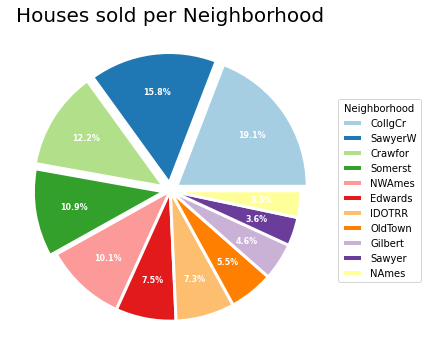

In [15]:
colors = sns.color_palette('Paired', 20)
values = df['%_ventes_totales']
names = df['Neighborhood']

def func(data):
    return "{:.1f}%".format(data)

fig, ax = plt.subplots(figsize=(20, 6), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(values, autopct=lambda values: func(values),
                                  textprops=dict(color="w",weight="bold"), colors=colors, 
                                  explode = (0.06, 0.06, 0.06, 0.05, 0, 0, 0, 0, 0, 0, 0),
                                  pctdistance=0.7,
                                  wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })

ax.legend(wedges, names,
          title="Neighborhood",
          loc="center left",
          bbox_to_anchor=(1,0,0.5,1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Houses sold per Neighborhood",fontsize = 20);

### par type de maison

In [16]:
query = """ 
WITH houses_sold AS (
SELECT  hb.Id, 
Neighborhood,
BedroomAbvGr,
YearBuilt,
GrLivArea,
SalePrice,
agent_id,
date_transac
FROM house_basic as hb
LEFT JOIN transactions AS t ON t.id = hb.Id
WHERE date_transac NOT NULL)

SELECT 
        AVG(BedroomAbvGr) AS nb_moyen_chambres,
        AVG(GrLivArea) AS m2_moyen,
        AVG(SalePrice) AS prix_moyen
FROM houses_sold

"""

df = pd.read_sql(query, conn)
df

,nb_moyen_chambres,m2_moyen,prix_moyen
0,3.095238,1678.47619,185746.380952


In [17]:
query = """ 

SELECT  
count(Neighborhood) AS parc,
AVG(BedroomAbvGr) nb_chambres_moyen_parc,
AVG(GrLivArea) AS surface_moyenne_parc,
AVG(SalePrice) AS prix_moyen_parc
FROM house_basic as hb
LEFT JOIN transactions AS t ON t.id = hb.Id
WHERE date_transac is NULL

"""

df = pd.read_sql(query, conn)
df

,parc,nb_chambres_moyen_parc,surface_moyenne_parc,prix_moyen_parc
0,1439,2.863099,1513.084781,180850.779708


## KPI - par temporalité

### par an

In [18]:
query = """ 
SELECT  
strftime('%Y',date_transac) AS year,
sum(SalePrice) AS ventes_totales
FROM house_basic as hb
LEFT JOIN transactions AS t ON t.id = hb.Id
WHERE date_transac NOT NULL
GROUP BY year
ORDER BY date(date_transac)

"""

df_time_annee = pd.read_sql(query, conn)
df_time_annee

,year,ventes_totales
0,2020,916964
1,2021,936750
2,2022,2046960


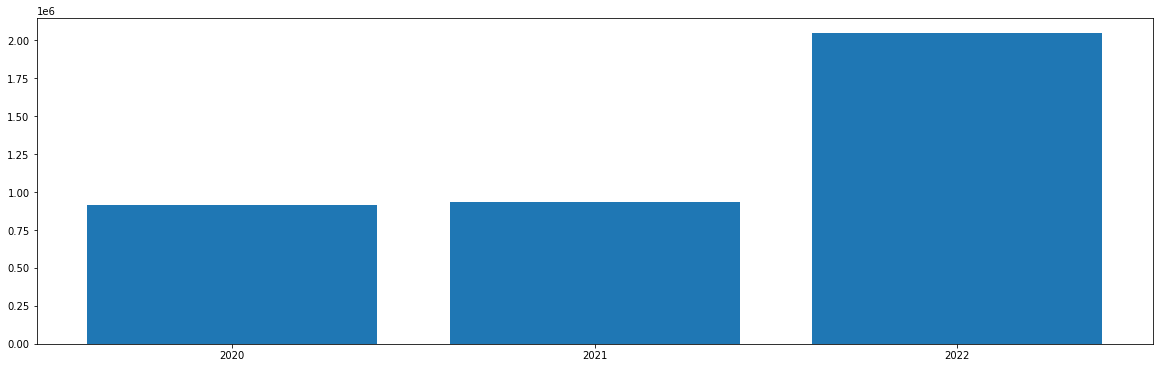

In [19]:
plt.figure(figsize=(20,6))
plt.bar(df_time_annee['year'],df_time_annee['ventes_totales']);

### par mois

In [20]:
query = """ 
SELECT  
strftime('%m-%Y',date_transac) AS month_year,
sum(SalePrice) AS ventes_totales
FROM house_basic as hb
LEFT JOIN transactions AS t ON t.id = hb.Id
WHERE date_transac NOT NULL
GROUP BY month_year
ORDER BY date(date_transac)

"""

df_time = pd.read_sql(query, conn)
df_time

,month_year,ventes_totales
0,04-2020,329000
1,08-2020,178000
2,10-2020,291000
3,12-2020,118964
4,02-2021,128950
5,05-2021,198900
6,06-2021,317000
7,11-2021,291900
8,01-2022,374500
9,03-2022,500000


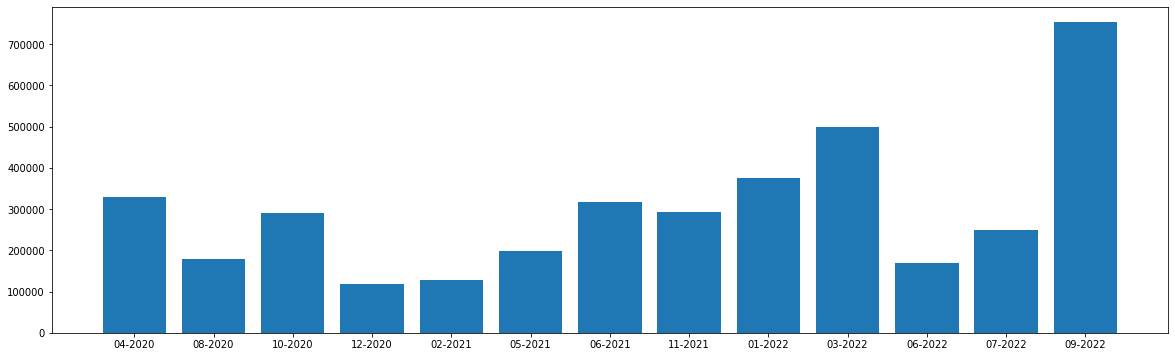

In [21]:
plt.figure(figsize=(20,6))
plt.bar(df_time['month_year'],df_time['ventes_totales']);